**This notebook use information from** <br/>
https://www.tensorflow.org/tutorials/audio/music_generation?hl=zh-cn <br/>
and <br/>
https://www.kaggle.com/code/karnikakapoor/music-generation-lstm/notebook

**Following steps are involved in the model building**

· Initialising the Model<br/>
· Defining by adding layers<br/>
· Compiling the Model<br/>
· Training the Model<br/>

**1.Import libraries**

In [1]:
import numpy as np
import os
import pandas as pd 
from collections import Counter
import random
import IPython
from IPython.display import Image, Audio
import matplotlib.pyplot as plt 
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

import tensorflow.keras.backend as K
from tensorflow.keras.optimizers import Adamax
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
%matplotlib inline
import sys
import pathlib
import warnings

import collections
import datetime
import fluidsynth
import glob
import pathlib
import pretty_midi
from music21 import *
import tensorflow
from midi2audio import FluidSynth
# from IPython import display
from typing import Dict, List, Optional, Sequence, Tuple

warnings.filterwarnings("ignore")
warnings.simplefilter("ignore")
np.random.seed(42)

**2.Load datas**

In [8]:
import pickle
with open('mapping.pkl', 'rb') as f:
    mapping = pickle.load(f)

with open('reverse_mapping.pkl', 'rb') as f:
    reverse_mapping = pickle.load(f)

with open('L_corpus.pkl', 'rb') as f:
    L_corpus = pickle.load(f)

with open('L_symb.pkl', 'rb') as f:
    L_symb = pickle.load(f)
    
with open('Corpus.pkl', 'rb') as f:
    Corpus = pickle.load(f)


**Encoding and Splitting the Corpus as Labels and Targets**

In [9]:
#Splitting the Corpus in equal length of strings and output target
length = 40
features = [] # 这两行创建了两个空列表，分别用来存储训练数据的输入特征（即音符序列）和目标（即接下来的音符）。
targets = []
for i in range(0, L_corpus - length, 1):
    feature = Corpus[i:i + length]
    target = Corpus[i + length]
    features.append([mapping[j] for j in feature])
    targets.append(mapping[target])
    
    
L_datapoints = len(targets)
print("Total number of sequences in the Corpus:", L_datapoints)

Total number of sequences in the Corpus: 55762


In [10]:
# reshape X and normalize
X = (np.reshape(features, (L_datapoints, length, 1)))/ float(L_symb)
# one hot encode the output variable
y = tensorflow.keras.utils.to_categorical(targets) 

In [11]:
#Taking out a subset of data to be used as seed
X_train, X_seed, y_train, y_seed = train_test_split(X, y, test_size=0.2, random_state=42)

**3.Building the Model**

In [12]:
#Initialising the Model
model = Sequential()
#Adding layers
model.add(LSTM(512, input_shape=(X.shape[1], X.shape[2]), return_sequences=True)) #添加第一个长短时记忆（LSTM）层，其中有512个神经元。LSTM层通常用于处理序列数据。
#X shape is(L_datapoints, length, 1)，
#X.shape[1]and X.shape[2] means the second and the third feature of X shape，which are ‘length’and‘1’
model.add(Dropout(0.1))
#Dropout Layer: This layer is a special type of layer used to "drop" a random fraction of the neurons' outputs during training. 
#By doing so, the network is forced to learn more robust and generalized representations.
model.add(LSTM(256))
model.add(Dense(256))
model.add(Dropout(0.1))
model.add(Dense(y.shape[1], activation='softmax'))
#Compiling the model for training  
opt = Adamax(learning_rate=0.01)
model.compile(loss='categorical_crossentropy', optimizer=opt)

In [13]:
#Model's Summary               
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 40, 512)           1052672   
                                                                 
 dropout (Dropout)           (None, 40, 512)           0         
                                                                 
 lstm_1 (LSTM)               (None, 256)               787456    
                                                                 
 dense (Dense)               (None, 256)               65792     
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 229)               58853     
                                                                 
Total params: 1,964,773
Trainable params: 1,964,773
Non-

In [14]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [15]:
#Training the Model
history = model.fit(X_train, y_train, batch_size=256, epochs=100)

Epoch 1/100
175/175 [==============================] - 11s 22ms/step - loss: 4.3469
Epoch 2/100
175/175 [==============================] - 4s 21ms/step - loss: 4.2707
Epoch 3/100
175/175 [==============================] - 4s 21ms/step - loss: 4.2661
Epoch 4/100
175/175 [==============================] - 4s 21ms/step - loss: 4.2638
Epoch 5/100
175/175 [==============================] - 4s 21ms/step - loss: 4.2609
Epoch 6/100
175/175 [==============================] - 4s 21ms/step - loss: 4.2607
Epoch 7/100
175/175 [==============================] - 4s 21ms/step - loss: 4.2599
Epoch 8/100
175/175 [==============================] - 4s 21ms/step - loss: 4.2580
Epoch 9/100
175/175 [==============================] - 4s 21ms/step - loss: 4.2587
Epoch 10/100
175/175 [==============================] - 4s 21ms/step - loss: 4.2575
Epoch 11/100
175/175 [==============================] - 4s 21ms/step - loss: 4.2566
Epoch 12/100
175/175 [==============================] - 4s 21ms/step - loss: 4.2567


In [16]:
# 保存整个模型
model.save('model_X+notes.h5')

# 加载模型
#from tensorflow.keras.models import load_model
#model = load_model('model_filename.h5')


**Plotting the learning curve for the loss function**

[Text(0.5, 0, 'Epochs')]

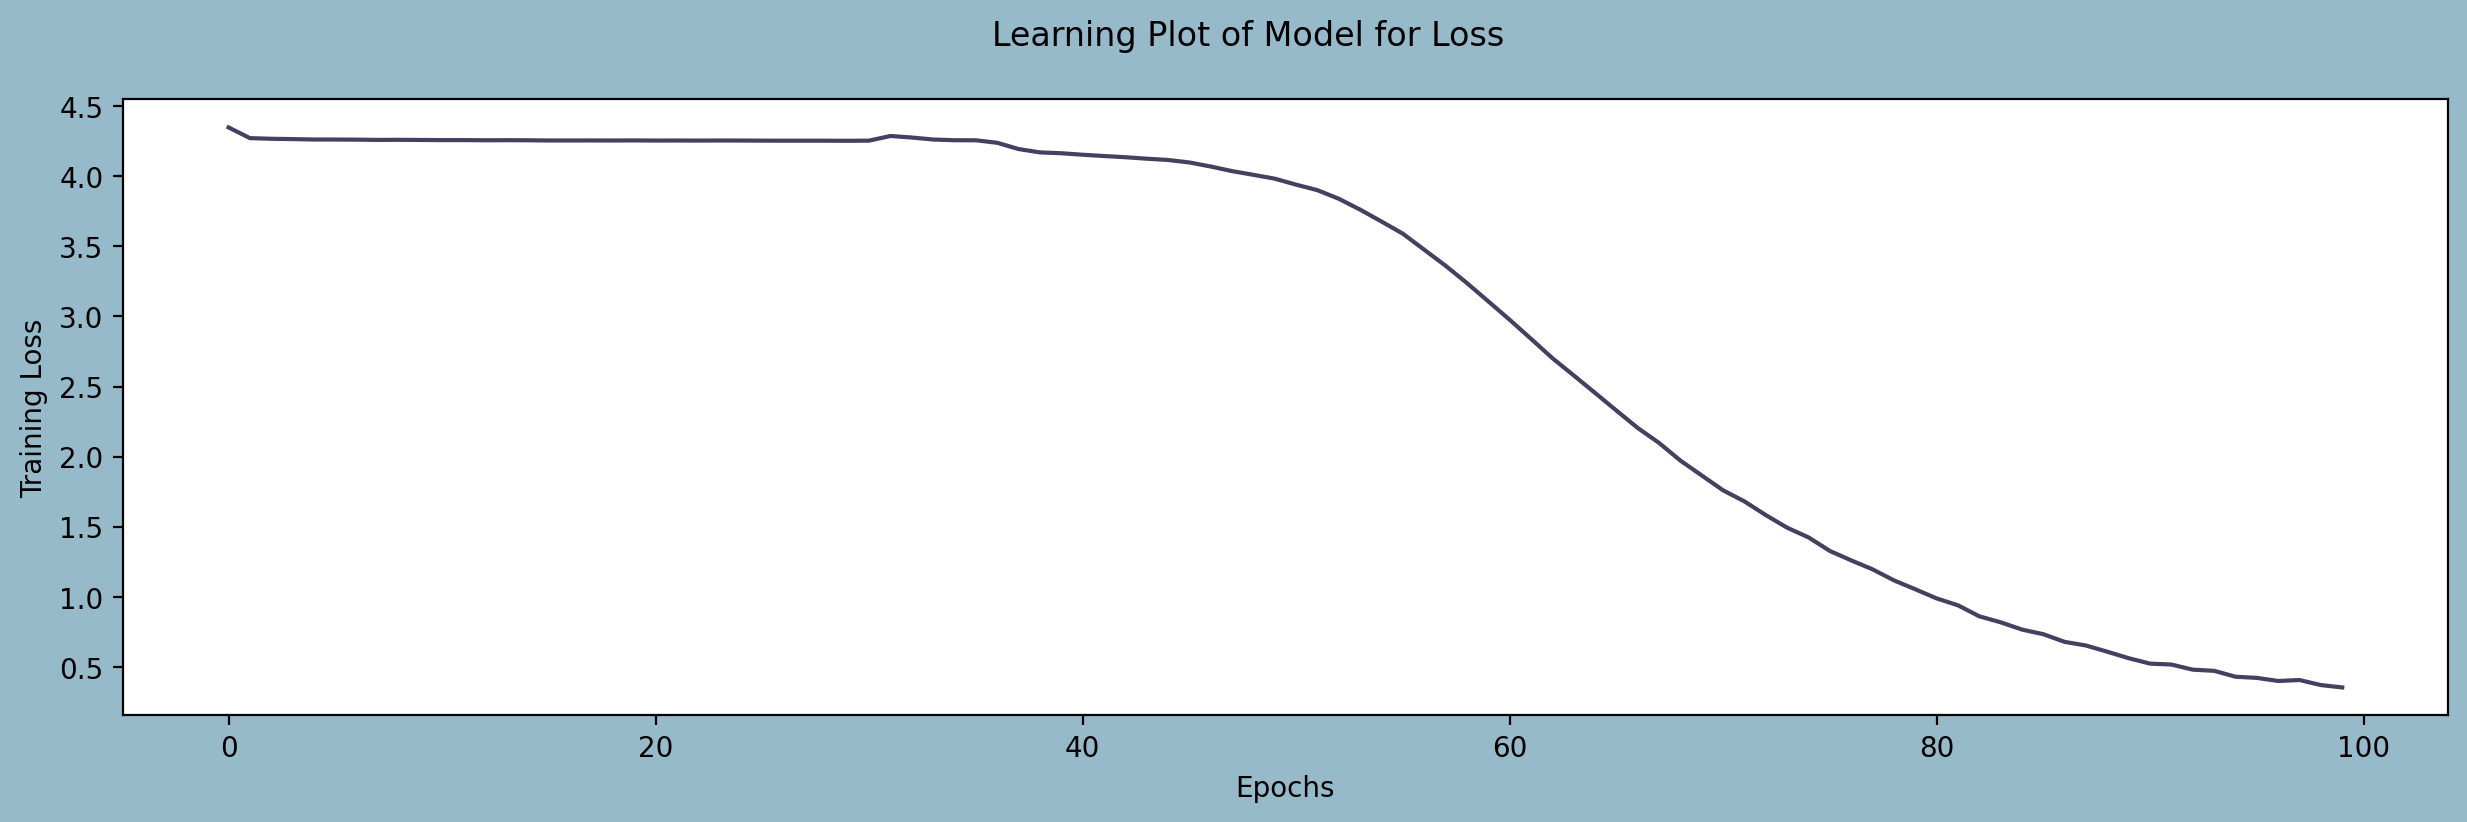

In [17]:
#Plotting the learnings 
history_df = pd.DataFrame(history.history)
fig = plt.figure(figsize=(15,4), facecolor="#97BACB")
fig.suptitle("Learning Plot of Model for Loss")
pl=sns.lineplot(data=history_df["loss"],color="#444160")
pl.set(ylabel ="Training Loss")
pl.set(xlabel ="Epochs")